In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import imageio
from tqdm.notebook import tqdm
plt.ion()
%matplotlib notebook

In [2]:
def get_kernel(n,r0):
    x=np.fft.fftfreq(n)*n
    rsqr=np.outer(np.ones(n),x**2)
    rsqr=rsqr+rsqr.T
    rsqr[rsqr<r0**2]=r0**2
    kernel=rsqr**-0.5
    return kernel


class Particles:
    def __init__(self,npart = 10000,n = 100,ndim = 2,periodic = True,soft = 1):
        self.npart = npart
        self.x = np.empty([npart,ndim])
        self.v = np.empty([npart,ndim])
        self.grad = np.empty([npart,ndim])
        self.f = np.empty([npart,ndim])
        self.ngrid=n
        self.masses = np.ones(self.npart)
        self.soft = soft
        self.periodic = periodic
        self.kernel = None
        self.kernelft = None
        self.init_xbounds = None
        self.init_ybounds = None
        if periodic:
            self.rho=np.empty([self.ngrid,self.ngrid])
            self.pot=np.empty([self.ngrid,self.ngrid])
        else:
            self.rho=np.empty([2*self.ngrid,2*self.ngrid])
            self.pot=np.empty([2*self.ngrid,2*self.ngrid])
    def get_rho(self):
        if self.periodic:
            self.rho=np.histogram2d(self.x[:,0],self.x[:,1],bins = self.ngrid,range = ([np.min(self.x[:,0])
                                                                            ,np.max(self.x[:,0])],[np.min(self.x[:,1])
                                                                            ,np.max(self.x[:,1])]),weights = self.masses)[0]
        else:
            self.rho[self.ngrid//2:3*self.ngrid//2,self.ngrid//2:3*self.ngrid//2] = np.histogram2d(self.x[:,0],self.x[:,1]
                                                                            ,bins = self.ngrid,range = ([np.min(self.x[:,0])
                                                                            ,np.max(self.x[:,0])],[np.min(self.x[:,1])
                                                                            ,np.max(self.x[:,1])]),weights = self.masses)[0]
    
    def IC_Gauss(self,n_blobs = 1,center_loc = [[0,0]],stds=[1,1]):
        if n_blobs!=len(center_loc) or n_blobs!=len(center_loc):
            print('Need to specify center and std of each blob')
            
        to_remove = self.npart%n_blobs
        self.npart-=to_remove
        parts_per_blob = self.npart//n_blobs
        
        for i in range(n_blobs):
            self.x[i*parts_per_blob:(i+1)*parts_per_blob] = np.random.normal(center_loc[i],stds[i],np.shape(self.x[:parts_per_blob]))
        
        self.init_xbounds = [np.min(self.x[:,0]),np.max(self.x[:,0])]
        self.init_ybounds = [np.min(self.x[:,1]),np.max(self.x[:,1])]
        
    def get_kernel(self):
        if self.periodic:
            self.kernel=get_kernel(self.ngrid,self.soft)
        else:
            self.kernel=get_kernel(2*self.ngrid,self.soft)
        self.kernelft=np.fft.rfft2(self.kernel)
        
    def get_potential(self):
        self.get_rho()
        self.get_kernel()
        rhoft = np.fft.rfft2(self.rho)
        conv = np.fft.irfft2(self.kernelft*rhoft)
        self.pot = conv
        
    def get_forces(self):
        gradx = 0.5*(np.roll(self.pot,1,0)-np.roll(self.pot,-1,0))
        grady = 0.5*(np.roll(self.pot,1,1)-np.roll(self.pot,-1,1))
        for i, xy in enumerate(self.x):
            xgrid = int(self.ngrid*(xy[0]-np.min(self.x[:,0]))/np.ptp(self.x[:,0]))
            if xgrid == self.ngrid:
                xgrid-=1
            ygrid = int(self.ngrid*(xy[1]-np.min(self.x[:,1]))/np.ptp(self.x[:,1]))
            if ygrid == self.ngrid:
                ygrid-=1
            self.f[i] = [-gradx[xgrid,ygrid],-grady[xgrid,ygrid]]
    
            
    def take_step(self,dt=1):
        self.x[:]=self.x[:]+dt*self.v
        self.get_potential()
        self.get_forces()
        self.v[:]=self.v[:]+self.f*dt
    
    def plot_particles(self,density=False,savepath = ''):
        if density:
            plt.figure()
            plt.hist2d(self.x[:,0],self.x[:,1],bins = self.ngrid,cmap = 'plasma',range = (self.init_xbounds,self.init_ybounds))
        else:
            plt.figure()
            plt.plot(self.x[:,0],self.x[:,1],'.')
        if savepath !='':
            plt.savefig(savepath)
    
    

In [3]:
particles = Particles(npart = 1000,n=200)

<IPython.core.display.Javascript object>


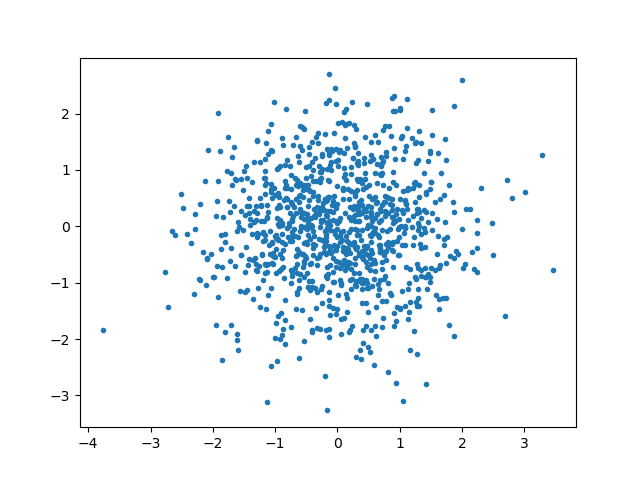

In [4]:
particles.IC_Gauss()
# particles.IC_box(bounds = [[-2,2],[-2,2]])
# particles.x[len(particles.x)//2:] = np.random.normal([5,5],0.01,size = np.shape(particles.x[len(particles.x)//2:]))
particles.v = np.zeros(np.shape(particles.v))
particles.plot_particles()

<IPython.core.display.Javascript object>


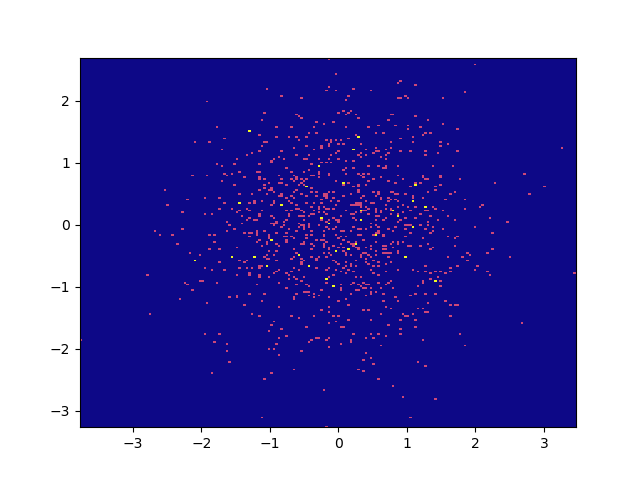

In [5]:
particles.get_rho()
particles.plot_particles(density=True)

<IPython.core.display.Javascript object>


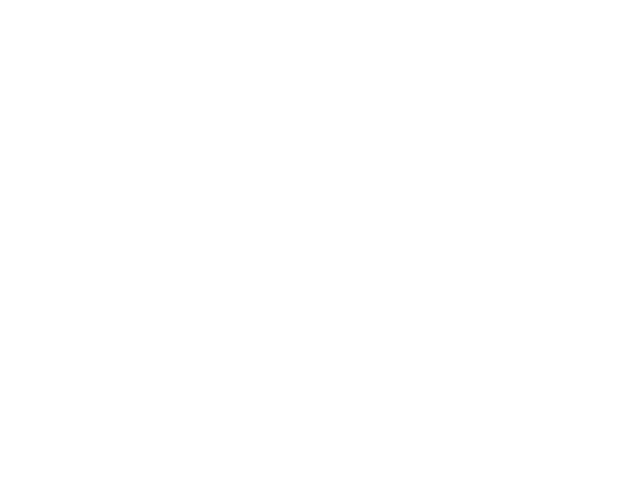

In [6]:
plt.figure()
particles.get_potential()
plt.imshow(np.rot90(particles.pot),cmap = 'plasma')

In [7]:
def make_animation(particles,niter,dt = 0.08):
    plt.clf()
    plt.ioff()
    path = 'Figures/Animation_{}_particles_{}_iter/'.format(particles.npart,niter)
    try:
        os.mkdir(path)
    except:
        None
        
    particles.plot_particles(density = True,savepath =path+'%04d'%0 )
    
    for i in tqdm(range(niter)):
        particles.take_step(dt = dt)
        particles.plot_particles(density = True,savepath = path+'%04d'%i)
        plt.close()
    images = []
    filenames = os.listdir(path)
    for filename in filenames:
        images.append(imageio.imread(path+filename))
    imageio.mimsave(path+'{}_particles_{}_iter.gif'.format(particles.npart,niter), images)
    plt.ion()

In [9]:
make_animation(particles,100,dt = 0.03)